

1. I used two transformer layer in the encoder instead of four.
2. I used four attention heads instead of two.
3. I used new tokens for SOS, EOS, and padding (very minor since Rohith used rare tokens for these purposes, but still- more 'correct').
2. I fixed a bug (probably?) in the decoder's dropout layers, which did not have the training flag, resulting in dropout during inference. This change gave a nice bump in the score.
3. I made the passing of the training flag explicit. I know it can be implicit since it is a kwarg, but explicit passing makes the whole thing more straightforward and maybe fix another one or two training-flag-related bugs along the way.
4. I changed the positional encoding in the decoder from tf.keras.layers.Embedding to proper positional embeddings (i.e., the usual sines and cosines usually used for this purpose). This had a significant impact.
5. I added positional embedding to the encoder. This, too, had a significant impact.


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import Levenshtein as lev
import os
import gc

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
inpdir = "/kaggle/input/asl-fingerspelling"
df = pd.read_csv(f'{inpdir}/train.csv')
df["phrase_bytes"] = df["phrase"].map(lambda x: x.encode("utf-8"))
display(df.head())

,path,file_id,sequence_id,participant_id,phrase,phrase_bytes
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,b'3 creekhouse'
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,b'scales/kuhaylah'
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,b'1383 william lanier'
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,b'988 franklin lane'
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,b'6920 northeast 661st road'


In [3]:
train_landmarks = pd.read_parquet('/kaggle/input/asl-fingerspelling/train_landmarks/1019715464.parquet')
keys = train_landmarks.keys()[1:]
train_landmarks.head()

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1975433633,0,0.578892,0.578482,0.582906,0.572686,0.579030,0.582115,0.591430,0.498995,0.595773,...,-0.253687,-0.291687,-0.123892,-0.195255,-0.249135,-0.284375,-0.125050,-0.187797,-0.224827,-0.249662
1975433633,1,0.577563,0.578528,0.582916,0.572760,0.579090,0.582197,0.591687,0.497613,0.596104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975433633,2,0.576181,0.576949,0.581346,0.572293,0.577725,0.581191,0.591550,0.497113,0.596477,...,-0.233556,-0.267114,-0.116145,-0.179053,-0.223861,-0.253004,-0.122090,-0.173169,-0.200727,-0.219106
1975433633,3,0.575575,0.577569,0.581769,0.572443,0.578289,0.581652,0.591728,0.496759,0.596573,...,-0.190909,-0.218471,-0.093956,-0.149982,-0.188452,-0.211573,-0.102759,-0.147642,-0.168562,-0.180578
1975433633,4,0.577907,0.577628,0.582295,0.572930,0.578345,0.581873,0.592467,0.498170,0.597383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# TFRecord

In [4]:
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

RHAND_LBLS = [f'x_right_hand_{i}' for i in range(21)] + [f'y_right_hand_{i}' for i in range(21)] + [f'z_right_hand_{i}' for i in range(21)]
LHAND_LBLS = [ f'x_left_hand_{i}' for i in range(21)] + [ f'y_left_hand_{i}' for i in range(21)] + [ f'z_left_hand_{i}' for i in range(21)]
POSE_LBLS = [f'x_pose_{i}' for i in POSE] + [f'y_pose_{i}' for i in POSE] + [f'z_pose_{i}' for i in POSE]

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

SEL_COLS = X + Y + Z
FRAME_LEN = 128

X_IDX = [i for i, col in enumerate(SEL_COLS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(SEL_COLS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(SEL_COLS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in LPOSE]

print('SEL_COLS size:' + str(len(SEL_COLS)))

SEL_COLS size:156


In [5]:
def load_relevant_data_subset(pq_path):
    return pd.read_parquet(pq_path, columns=SEL_COLS)

counter = 0
for file_id in tqdm(df.file_id.unique()):
    
    print(counter)
    counter+=1
    
    pqfile = f"{inpdir}/train_landmarks/{file_id}.parquet"
    if not os.path.isdir("tfds"): os.mkdir("tfds")
    tffile = f"tfds/{file_id}.tfrecord"
    seq_refs = df.loc[df.file_id == file_id]
    seqs = load_relevant_data_subset(pqfile)
    seqs_numpy = seqs.to_numpy()
    with tf.io.TFRecordWriter(tffile) as file_writer:
        for seq_id, phrase in zip(seq_refs.sequence_id, seq_refs.phrase_bytes):
            frames = seqs_numpy[seqs.index == seq_id]
            
            r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
            l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
            no_nan = max(r_nonan, l_nonan)
            
            if 2*len(phrase)<no_nan:
                features = {SEL_COLS[i]: tf.train.Feature(
                    float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(SEL_COLS))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[phrase]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)

  0%|          | 0/68 [00:00<?, ?it/s]

0


  1%|▏         | 1/68 [00:08<09:49,  8.80s/it]

1


  3%|▎         | 2/68 [00:18<10:26,  9.49s/it]

2


  4%|▍         | 3/68 [00:28<10:18,  9.51s/it]

3


  6%|▌         | 4/68 [00:38<10:18,  9.66s/it]

4


  7%|▋         | 5/68 [00:48<10:18,  9.81s/it]

5


  9%|▉         | 6/68 [00:58<10:12,  9.88s/it]

6


 10%|█         | 7/68 [01:07<09:57,  9.79s/it]

7


 12%|█▏        | 8/68 [01:17<09:52,  9.87s/it]

8


 13%|█▎        | 9/68 [01:27<09:41,  9.85s/it]

9


 15%|█▍        | 10/68 [01:37<09:30,  9.84s/it]

10


 16%|█▌        | 11/68 [01:48<09:42, 10.22s/it]

11


 18%|█▊        | 12/68 [01:58<09:29, 10.17s/it]

12


 19%|█▉        | 13/68 [02:08<09:10, 10.00s/it]

13


 21%|██        | 14/68 [02:11<07:03,  7.84s/it]

14


 22%|██▏       | 15/68 [02:21<07:29,  8.49s/it]

15


 24%|██▎       | 16/68 [02:30<07:37,  8.80s/it]

16


 25%|██▌       | 17/68 [02:40<07:44,  9.11s/it]

17


 26%|██▋       | 18/68 [02:50<07:51,  9.42s/it]

18


 28%|██▊       | 19/68 [03:00<07:49,  9.58s/it]

19


 29%|██▉       | 20/68 [03:10<07:46,  9.72s/it]

20


 31%|███       | 21/68 [03:20<07:38,  9.75s/it]

21


 32%|███▏      | 22/68 [03:30<07:36,  9.91s/it]

22


 34%|███▍      | 23/68 [03:40<07:18,  9.74s/it]

23


 35%|███▌      | 24/68 [03:50<07:11,  9.80s/it]

24


 37%|███▋      | 25/68 [04:00<07:06,  9.91s/it]

25


 38%|███▊      | 26/68 [04:09<06:52,  9.81s/it]

26


 40%|███▉      | 27/68 [04:19<06:37,  9.69s/it]

27


 41%|████      | 28/68 [04:29<06:31,  9.80s/it]

28


 43%|████▎     | 29/68 [04:38<06:17,  9.67s/it]

29


 44%|████▍     | 30/68 [04:48<06:04,  9.59s/it]

30


 46%|████▌     | 31/68 [04:57<05:57,  9.66s/it]

31


 47%|████▋     | 32/68 [05:06<05:37,  9.37s/it]

32


 49%|████▊     | 33/68 [05:16<05:35,  9.59s/it]

33


 50%|█████     | 34/68 [05:26<05:25,  9.57s/it]

34


 51%|█████▏    | 35/68 [05:36<05:24,  9.83s/it]

35


 53%|█████▎    | 36/68 [05:46<05:13,  9.80s/it]

36


 54%|█████▍    | 37/68 [05:55<04:58,  9.63s/it]

37


 56%|█████▌    | 38/68 [06:05<04:49,  9.64s/it]

38


 57%|█████▋    | 39/68 [06:14<04:36,  9.55s/it]

39


 59%|█████▉    | 40/68 [06:23<04:24,  9.44s/it]

40


 60%|██████    | 41/68 [06:33<04:13,  9.39s/it]

41


 62%|██████▏   | 42/68 [06:42<04:07,  9.50s/it]

42


 63%|██████▎   | 43/68 [06:52<03:57,  9.51s/it]

43


 65%|██████▍   | 44/68 [07:02<03:49,  9.58s/it]

44


 66%|██████▌   | 45/68 [07:11<03:42,  9.68s/it]

45


 68%|██████▊   | 46/68 [07:21<03:29,  9.51s/it]

46


 69%|██████▉   | 47/68 [07:30<03:18,  9.44s/it]

47


 71%|███████   | 48/68 [07:40<03:12,  9.64s/it]

48


 72%|███████▏  | 49/68 [07:50<03:04,  9.74s/it]

49


 74%|███████▎  | 50/68 [07:59<02:53,  9.62s/it]

50


 75%|███████▌  | 51/68 [08:09<02:41,  9.52s/it]

51


 76%|███████▋  | 52/68 [08:18<02:32,  9.51s/it]

52


 78%|███████▊  | 53/68 [08:28<02:23,  9.56s/it]

53


 79%|███████▉  | 54/68 [08:37<02:13,  9.52s/it]

54


 81%|████████  | 55/68 [08:47<02:04,  9.57s/it]

55


 82%|████████▏ | 56/68 [08:56<01:54,  9.51s/it]

56


 84%|████████▍ | 57/68 [09:06<01:44,  9.49s/it]

57


 85%|████████▌ | 58/68 [09:15<01:35,  9.56s/it]

58


 87%|████████▋ | 59/68 [09:25<01:26,  9.63s/it]

59


 88%|████████▊ | 60/68 [09:35<01:16,  9.62s/it]

60


 90%|████████▉ | 61/68 [09:44<01:07,  9.63s/it]

61


 91%|█████████ | 62/68 [09:54<00:58,  9.70s/it]

62


 93%|█████████▎| 63/68 [10:04<00:48,  9.67s/it]

63


 94%|█████████▍| 64/68 [10:13<00:37,  9.45s/it]

64


 96%|█████████▌| 65/68 [10:23<00:28,  9.58s/it]

65


 97%|█████████▋| 66/68 [10:32<00:19,  9.56s/it]

66


 99%|█████████▊| 67/68 [10:42<00:09,  9.50s/it]

67


100%|██████████| 68/68 [10:51<00:00,  9.58s/it]


# Data loading

#### Here I use new tokens for padding, start and end of sentences. (Capitals are good since the original phrases have only lower case letters, besides numbers and various signs).

In [6]:
pad_token = 'P'
start_token = 'S'
end_token = 'E'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

In [7]:
with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)


char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx

num_to_char = {j:i for i,j in char_to_num.items()}


inpdir = "/kaggle/input/asl-fingerspelling"
df = pd.read_csv(f'{inpdir}/train.csv')

LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

RHAND_LBLS = [f'x_right_hand_{i}' for i in range(21)] + [f'y_right_hand_{i}' for i in range(21)] + [f'z_right_hand_{i}' for i in range(21)]
LHAND_LBLS = [ f'x_left_hand_{i}' for i in range(21)] + [ f'y_left_hand_{i}' for i in range(21)] + [ f'z_left_hand_{i}' for i in range(21)]
POSE_LBLS = [f'x_pose_{i}' for i in POSE] + [f'y_pose_{i}' for i in POSE] + [f'z_pose_{i}' for i in POSE]

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

SEL_COLS = X + Y + Z
FRAME_LEN = 128

X_IDX = [i for i, col in enumerate(SEL_COLS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(SEL_COLS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(SEL_COLS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(SEL_COLS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(SEL_COLS)  if  "pose" in col and int(col[-2:]) in LPOSE]

print(RPOSE_IDX)

[47, 48, 49, 50, 51, 99, 100, 101, 102, 103, 151, 152, 153, 154, 155]


{0: ' ', 1: '!', 2: '#', 3: '$', 4: '%', 5: '&', 6: "'", 7: '(', 8: ')', 9: '*', 10: '+', 11: ',', 12: '-', 13: '.', 14: '/', 15: '0', 16: '1', 17: '2', 18: '3', 19: '4', 20: '5', 21: '6', 22: '7', 23: '8', 24: '9', 25: ':', 26: ';', 27: '=', 28: '?', 29: '@', 30: '[', 31: '_', 32: 'a', 33: 'b', 34: 'c', 35: 'd', 36: 'e', 37: 'f', 38: 'g', 39: 'h', 40: 'i', 41: 'j', 42: 'k', 43: 'l', 44: 'm', 45: 'n', 46: 'o', 47: 'p', 48: 'q', 49: 'r', 50: 's', 51: 't', 52: 'u', 53: 'v', 54: 'w', 55: 'x', 56: 'y', 57: 'z', 58: '~', 59: 'P', 60: 'S', 61: 'E'}
add Codeadd Markdown

In [8]:
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
        print(x)
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose
    
    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

In [9]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def preprocess_fn(landmarks, phrase):
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)
    return pre_process(landmarks), phrase

def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in SEL_COLS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in SEL_COLS])
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

inpdir = "/kaggle/input/aslfr-parquets-to-tfrecords-cleaned"
tffiles = df.file_id.map(lambda x: f'{inpdir}/tfds/{x}.tfrecord').unique()

batch_size = 32
val_len = int(0.05 * len(tffiles))

train_dataset = tf.data.TFRecordDataset(tffiles[val_len:]).map(decode_fn).map(preprocess_fn).shuffle(30000, reshuffle_each_iteration=True).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = tf.data.TFRecordDataset(tffiles[:val_len]).map(decode_fn).map(preprocess_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

Tensor("cond_1/Pad:0", shape=(None, 26, 3), dtype=float32)
Tensor("cond_1/Pad:0", shape=(None, 26, 3), dtype=float32)


# The model

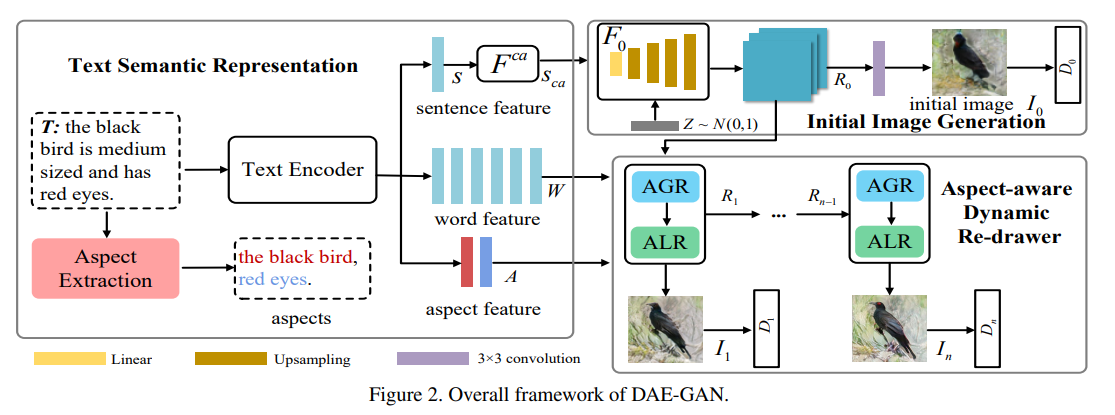
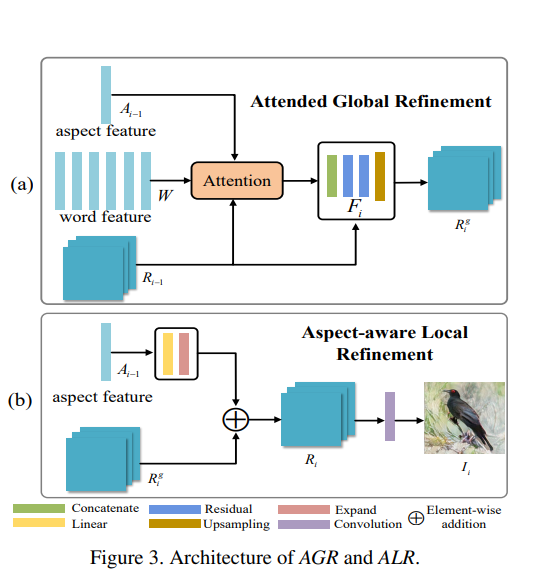
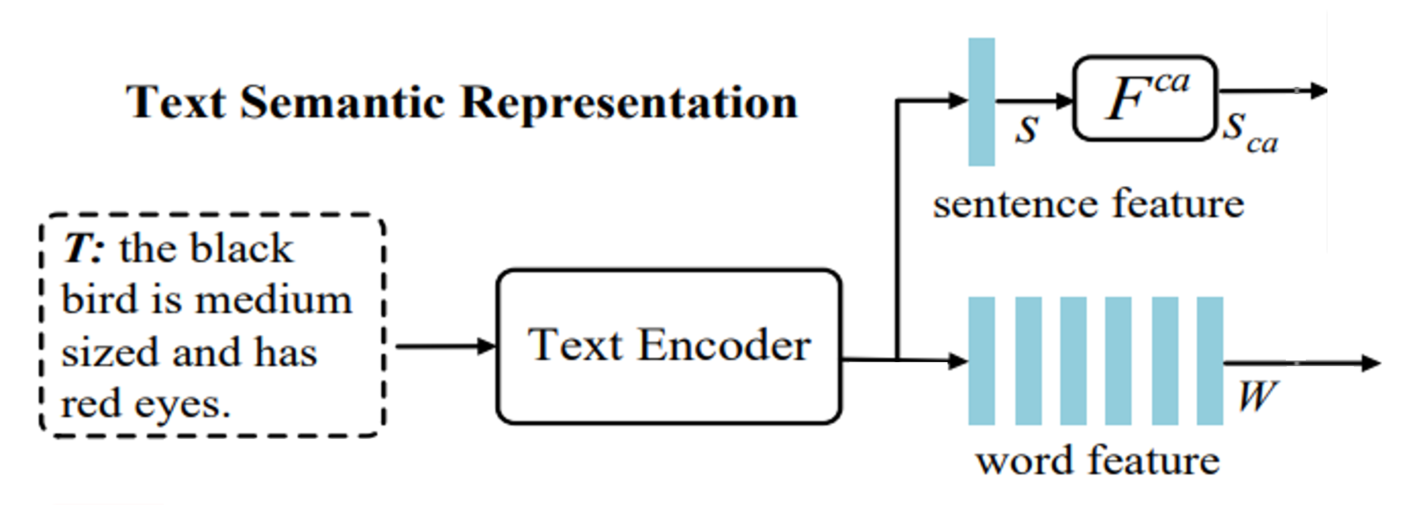

#### Here I implemented proper positional embeddings for both the encoder and the decoder.

In [10]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.num_hid = num_hid
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        #self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)
        '''
        self.pos_emb = tf.math.divide(
            self.positional_encoding(maxlen-1, num_hid),
            tf.math.sqrt(tf.cast(num_hid, tf.float32)))
        '''
        self.pos_emb = self.positional_encoding(maxlen-1, num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.num_hid, tf.float32)))
        '''
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions
        '''
        return x + self.pos_emb[:maxlen, :]
    
    def positional_encoding(self, maxlen, num_hid):
        depth = num_hid/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1) 
        return pos_encoding




In [11]:
class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, padding="same", activation="relu"
        )
        self.pos_emb = self.positional_encoding(maxlen, num_hid)
        self.maxlen = maxlen
        self.num_hid = num_hid

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = tf.math.multiply(x, tf.math.sqrt(tf.cast(self.num_hid, tf.float32)))
        x = x + self.pos_emb
        
        return x
    
    def positional_encoding(self, maxlen, num_hid):
        depth = num_hid/2
        positions = tf.range(maxlen, dtype = tf.float32)[..., tf.newaxis]
        depths = tf.range(depth, dtype = tf.float32)[np.newaxis, :]/depth
        angle_rates = tf.math.divide(1, tf.math.pow(tf.cast(10000, tf.float32), depths))
        angle_rads = tf.linalg.matmul(positions, angle_rates)
        pos_encoding = tf.concat(
          [tf.math.sin(angle_rads), tf.math.cos(angle_rads)],
          axis=-1) 
        return pos_encoding

In [12]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [13]:
import tensorflow as tf

# TFRecordファイルのパス
tfrecord_file = "/kaggle/working/tfds/128822441.tfrecord"

# TFRecordデータセットの作成
dataset = tf.data.TFRecordDataset([tfrecord_file])
print(dataset)

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


#### Here I added the training flag to the TransformerDecoder's Dropout layers.

In [14]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
        return ffn_out_norm

#### Here I made the passing of the training flag explicit.

In [15]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):        
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

In [16]:
batch = next(iter(val_dataset))
idx_to_char = list(char_to_num.keys())

model = Transformer(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen = FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=62,
)


loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)


optimizer = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn)

In [17]:
%%time
history = model.fit(train_dataset, verbose = 2, validation_data=val_dataset, epochs=20)

Epoch 1/20
1520/1520 - 175s - loss: 0.7825 - val_loss: 0.6380 - 175s/epoch - 115ms/step
Epoch 2/20
1520/1520 - 125s - loss: 0.5705 - val_loss: 0.5352 - 125s/epoch - 82ms/step
Epoch 3/20
1520/1520 - 156s - loss: 0.5094 - val_loss: 0.5043 - 156s/epoch - 103ms/step
Epoch 4/20
1520/1520 - 160s - loss: 0.4818 - val_loss: 0.4847 - 160s/epoch - 105ms/step
Epoch 5/20
1520/1520 - 155s - loss: 0.4632 - val_loss: 0.4752 - 155s/epoch - 102ms/step
Epoch 6/20
1520/1520 - 167s - loss: 0.4488 - val_loss: 0.4640 - 167s/epoch - 110ms/step
Epoch 7/20
1520/1520 - 159s - loss: 0.4375 - val_loss: 0.4617 - 159s/epoch - 105ms/step
Epoch 8/20
1520/1520 - 157s - loss: 0.4276 - val_loss: 0.4537 - 157s/epoch - 103ms/step
Epoch 9/20
1520/1520 - 156s - loss: 0.4188 - val_loss: 0.4538 - 156s/epoch - 103ms/step
Epoch 10/20
1520/1520 - 158s - loss: 0.4111 - val_loss: 0.4492 - 158s/epoch - 104ms/step
Epoch 11/20
1520/1520 - 156s - loss: 0.4038 - val_loss: 0.4481 - 156s/epoch - 103ms/step
Epoch 12/20
1520/1520 - 157s - 

In [18]:
print(model.summary())

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 landmark_embedding (Landmar  (None, 128, 200)         1052200   
 kEmbedding)                                                     
                                                                 
 token_embedding (TokenEmbed  multiple                 12400     
 ding)                                                           
                                                                 
 sequential_2 (Sequential)   (None, 128, 200)          2660200   
                                                                 
 transformer_decoder (Transf  multiple                 1447000   
 ormerDecoder)                                                   
                                                                 
 dense_6 (Dense)             multiple                  12462     
                                                       

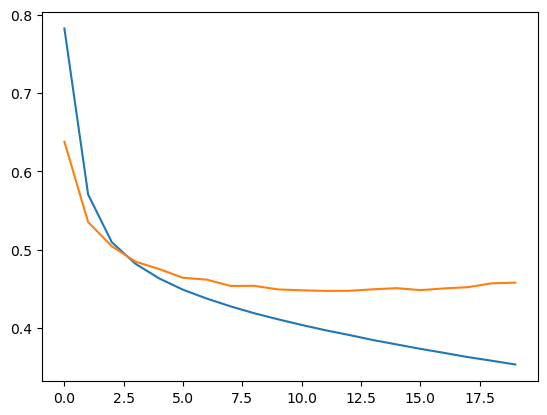

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Validation

In [20]:
batches = [batch for batch in val_dataset]

preds_list = []
ground_truth_list = []

for batch in batches[:1]:
    source = batch[0]
    target = batch[1].numpy()
    bs = tf.shape(source)[0]
    preds = model.generate(source, start_token_idx)
    preds = preds.numpy()

    for i in range(bs):
        target_text = "".join([idx_to_char[_] for _ in target[i, :]])
        ground_truth_list.append(target_text.replace('P', ''))
        prediction = ""
        for idx in preds[i, :]:
            prediction += idx_to_char[idx]
            if idx == end_token_idx:
                break
        preds_list.append(prediction)

for i in range(10):
    print(ground_truth_list[i])
    print(preds_list[i])
    print('\n~~~\n')

S3 creekhouseE
S3 creek houseE

~~~

Sscales/kuhaylahE
Sscales/coco/nguhayaE

~~~

S1383 william lanierE
S1385 william lanierE

~~~

S988 franklin laneE
S988 frandan laneE

~~~

S6920 northeast 661st roadE
S6920 northeast wast roadE

~~~

Swww.freem.ne.jpE
Swww.freem.me.jpE

~~~

Shttps://jsi.is/hukuokaE
Shttps://jsi.iti.is/hturokaE

~~~

S239613 stolze streetE
S23961 10told zeastreetE

~~~

S271097 bayshore boulevardE
S271097 bay nore boulevar rdE

~~~

Sfederico pearsonE
Sfeederico pearonE

~~~



In [21]:
ground_truth_processed = [ground_truth_list[i][1:-1] for i in range(len(ground_truth_list))]
preds_list_processed = [preds_list[i][1:-1] for i in range(len(preds_list))]
lev_dist = [lev.distance(ground_truth_processed[i], preds_list_processed[i]) 
            for i in range(len(preds_list_processed))]
N = [len(phrase) for phrase in ground_truth_processed]

print('Validation score: '+str((np.sum(N) - np.sum(lev_dist))/np.sum(N)))

Validation score: 0.7787307032590052


# TFLiteModel

In [22]:
 class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()
        self.target_start_token_idx = start_token_idx
        self.target_end_token_idx = end_token_idx
        # Load the feature generation and main models
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, len(SEL_COLS)], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs, training=False):
        # Preprocess Data
        x = tf.cast(inputs, tf.float32)
        x = x[None]
        x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(SEL_COLS))), lambda: tf.identity(x))
        x = x[0]
        x = pre_process(x)
        x = x[None]
        x = self.model.generate(x, self.target_start_token_idx)
        x = x[0]
        idx = tf.argmax(tf.cast(tf.equal(x, self.target_end_token_idx), tf.int32))
        idx = tf.where(tf.math.less(idx, 1), tf.constant(2, dtype=tf.int64), idx)
        x = x[1:idx]
        x = tf.one_hot(x, 59)
        return {'outputs': x}
    
tflitemodel_base = TFLiteModel(model)

In [23]:
model.save_weights("model.h5")

In [24]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflitemodel_base)
keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]#, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = keras_model_converter.convert()
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)
    
infargs = {"selected_columns" : SEL_COLS}

with open('inference_args.json', "w") as json_file:
    json.dump(infargs, json_file)

Tensor("cond_2/Pad:0", shape=(None, 26, 3), dtype=float32)


In [25]:
!zip submission.zip  './model.tflite' './inference_args.json'

  adding: model.tflite (deflated 19%)
  adding: inference_args.json (deflated 85%)


In [26]:
interpreter = tf.lite.Interpreter("model.tflite")

REQUIRED_SIGNATURE = "serving_default"
REQUIRED_OUTPUT = "outputs"

with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    character_map = json.load(f)
rev_character_map = {j:i for i,j in character_map.items()}

found_signatures = list(interpreter.get_signature_list().keys())

if REQUIRED_SIGNATURE not in found_signatures:
    raise KernelEvalException('Required input signature not found.')

prediction_fn = interpreter.get_signature_runner("serving_default")
output = prediction_fn(inputs=batch[0][0])
prediction_str = "".join([rev_character_map.get(s, "") for s in np.argmax(output[REQUIRED_OUTPUT], axis=1)])
print(prediction_str)

88 sosesesens
